In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import hydrant.topology.geom as gm
import matplotlib.pyplot as plt
from typing import (
    Union,
    List
)
from __future__ import annotations

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import subprocess
import os
from   shapely.geometry import Point

def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: Union[str, int, ...],
    main_id: str,
    ds_main_id: str,
) -> set[...]:
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns
    -------
    nodes: list
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf,
                                        source=main_id,
                                        target=ds_main_id,
                                        create_using=nx.DiGraph)

    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)

    # adding `target_id` as the last node of the branch
    nodes.add(target_id)

    return nodes

def main_branch(df):
    
    # Create a directed graph
    G = nx.DiGraph()

    # Add edges and assign upa as edge weight
    for _, row in df.iterrows():
        G.add_edge(row['next'], row['id'], weight=row['upa'])
        
    # get the longest distance weighted based on up area
    longest_path = nx.dag_longest_path(G, weight='weight')

    #print("Longest distance:", longest_path)
    
    # Set flag to 1 where id is in the array_to_check
    df ['main_branch'] = 0
    df.loc[df['id'].isin(longest_path), 'main_branch'] = 1
    
    return df

def pfaf_one_round(df):
    
    df['pfaf_temp'] = 1
    df = main_branch(df)
    
    #print('df',df)
    
    # Separate DataFrame based on flag value
    df_main      = df[df['main_branch'] == 1].sort_values(by='upa', ignore_index=True)
    
    if len(df) != len(df_main):
        
        # identify 4 largest upstream segments to main branch
        df_none_main = df[df['main_branch'] == 0].sort_values(by='upa', ignore_index=True, ascending=False)
        max_4_up = df_none_main.loc[df_none_main['next'].isin(df_main['id'])].head(4)
        max_4_up = max_4_up.sort_values(by='upa', ignore_index=True)

        # attach the uparea of the next down ID, which are on main ID, to the max_4_up dataframe
        max_4_up ['next_up_area'] = 0
        max_4_up ['up_confluence_main_id'] = 0
        for index, row in max_4_up.iterrows():
            # get the up area of df_main that is downstream of max_4_up
            max_4_up.loc[index,'next_up_area'] = df_main['upa'].loc[df_main['id']==row['next']].values
            index_temp = df_main.loc[df_main['id']==row['next']].index-1
            index_temp = np.array(index_temp).item()
            max_4_up.loc[index,'up_confluence_main_id'] = df_main['id'].loc[index_temp] #.loc[df_main.loc[df_main['id']==row['next']].index.values+1]

        max_4_up = max_4_up.sort_values(by='next_up_area', ignore_index=True)
        
        if max_4_up.empty:
            raise ValueError("Error: max_4_up is empty")

        # get the len of max_4_up unique elements
        if len(np.unique(max_4_up['next'])) == 4:
            odd_pfafs = [3,5,7,9]
        elif len(np.unique(max_4_up['next'])) == 3:
            odd_pfafs = [3,5,9]
        elif len(np.unique(max_4_up['next'])) == 2:
            odd_pfafs = [3,9]
        elif len(np.unique(max_4_up['next'])) == 1:
            odd_pfafs = [9]

        # get the len of max_4_up elements
        if len(max_4_up['next']) == 4:
            even_pfafs = [2,4,6,8]
        elif len(max_4_up['next']) == 3:
            even_pfafs = [2,4,6]
        elif len(max_4_up['next']) == 2:
            even_pfafs = [2,4]
        elif len(max_4_up['next']) == 1:
            even_pfafs = [2]

        # add the segment and station into a data frame
        seg_ids = np.array([])
        pfaf_codes = np.array([])

        # Add values to the array for main branch
        seg_ids = np.append(seg_ids, max_4_up['up_confluence_main_id'])
        pfaf_codes = np.append(pfaf_codes, np.flip(odd_pfafs, axis=0))

        # add values to array for tributaries
        seg_ids = np.append(seg_ids, max_4_up['id'])
        pfaf_codes = np.append(pfaf_codes, np.flip(even_pfafs, axis=0))
        zipped = zip(seg_ids, pfaf_codes)
        sorted_zipped = sorted(zipped, key=lambda x: x[1])

        # get the upstream and assign the pfaf from smaller values to largest values
        df ['pfaf_temp'] = 1

        for seg_id, pfaf_code in sorted_zipped:
            ids_selected = find_upstream(df, seg_id, 'id', 'next')
            # replace the ids in df
            indices = df[df['id'].isin(ids_selected)].index
            # Update 'flag' column to 1 for the rows with matching indices
            df.loc[indices, 'pfaf_temp'] = pfaf_code

    return df


def pfaf(df):
    
    # order_id
    order_id = df['id'].values
    
    # initial pfaf set up for the df
    df = pfaf_one_round (df)
    df ['pfaf'] = df ['pfaf_temp']
    
    
    for i in np.arange(2, 4):
        
        if len(df) != len(np.unique(df ['pfaf'])):
        
            df_slice_total = pd.DataFrame()

            for m in np.unique(df ['pfaf']):

                df_slice = df[df['pfaf']==m]
                df_slice = pfaf_one_round(df_slice)
                df_slice_total = pd.concat([df_slice_total,df_slice], ignore_index=True)

            df = df_slice_total.copy()

            print(df)
        else:
            
            df['pfaf_temp'] = 0

        # Convert values in column1 and column2 to strings
        df['pfaf'] = df['pfaf'].astype(str)
        df['pfaf_temp'] = df['pfaf_temp'].astype(str)

        # Concatenate the strings in column1 and column2
        df['pfaf'] = df['pfaf'] + df['pfaf_temp']

        # Convert the concatenated string back to integers
        df['pfaf'] = df['pfaf'].astype(int)
        
        
        df = df.set_index('id').loc[order_id].reset_index()
        
    return df

In [2]:
# Example data
data = {
    'id':   [1, 2, 3, 4,  5,  6,  7],
    'next': [3, 3, 5, 5,  7,  7,  8],
    'a':    [2, 3, 1, 6,  2,  7,  7],
    'upa':  [2, 3, 6, 6, 14,  7, 28],
}

# Create DataFrame
df = pd.DataFrame(data)

df = pfaf(df)

df

,id,next,a,upa,pfaf_temp,main_branch,pfaf
0,1,3,2,2,0,0,600
1,2,3,3,3,0,1,900
2,3,5,1,6,0,1,500
3,4,5,6,6,0,0,400
4,5,7,2,14,0,1,300
5,6,7,7,7,0,0,200
6,7,8,7,28,0,1,100


## Real case example

In [3]:
# inputs
path_out = './output/'
pfafs = ['71'] # 71 Saskatchewan, 78 Colombia
# riv_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cat_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
# cst_path = '/project/def-kshook/temp/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cat_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/pfaf_level_02/'
cst_path = '/project/def-kshook/uofc-share/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1/coastal_hillslopes/'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
cst_file_template = 'hillslope_*_clean.shp'

In [4]:
if not os.path.isdir(path_out):
    os.makedirs(path_out)

# Load and append the pfaf

In [5]:
riv, cat = gm.merit_read_file (pfafs,
                               riv_path,
                               riv_file_template,
                               cat_path,
                               cat_file_template,
                               path_cst = cst_path,
                               cst_file_template = cst_file_template)

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


# prepare the network topology

In [6]:
riv, cat = gm.prepare_ntopo(riv=riv,\
                            riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                            cat=cat,\
                            cat_cols={'id':'COMID', 'hillslope':'hillslope', 'area' :'unitarea'},\
                            network = 'merit')

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:491: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['latitude'] = cat.centroid.y
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/hydrant/topology/geom.py:492: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river['longitude'] = cat.centroid.x


# Example-3 From basins of identified pfafs that intersect with target stations in Alberta

In [7]:
# set the case name
prefix = 'stations_merit_'

In [8]:
data = {
    'Station ID': ['05BH004'],
    'seg ID': [71027942],
    'Station name': [
        'BOW RIVER AT CALGARY',
    ],
    'up': [0],
    'X': [-114.05],
    'Y': [  51.05]
}

# Create a DataFrame from the dictionary
stations_seg_id = pd.DataFrame(data)

# Create a points from the dictionary
geometry = [Point(xy) for xy in zip(data['X'], data['Y'])]
stations_points = gpd.GeoDataFrame(data, geometry=geometry, crs='EPSG:4326')

In [9]:
# slice the domain for various stations and their seg ID
cat_slice, riv_slice = gm.subset_ntopo(cat=cat,\
                                       cat_cols={'id':'COMID'},\
                                       riv=riv,\
                                       riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                       outlet_id=list(stations_seg_id['seg ID']))



<AxesSubplot:>

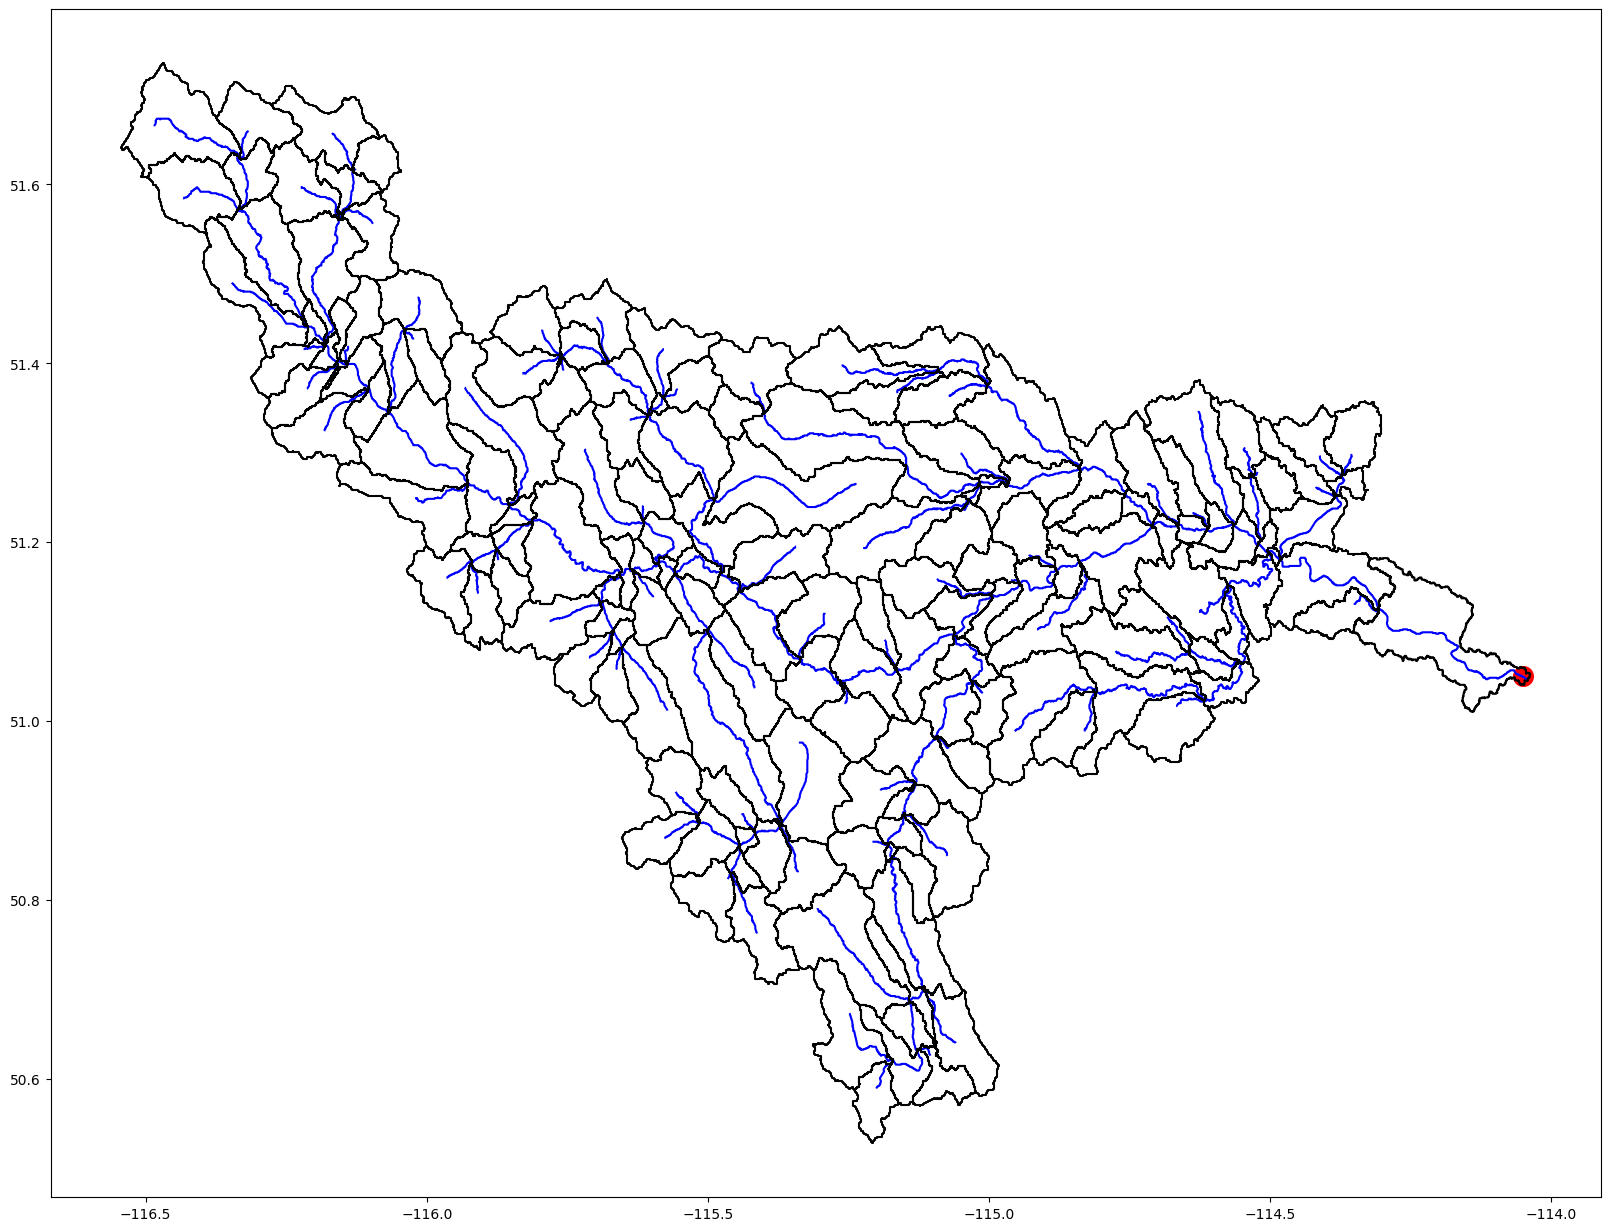

In [10]:
fig, ax = plt.subplots(figsize=(20,30))
riv_slice.plot(ax=ax, color='b')
cat_slice.boundary.plot(ax=ax, color='k')
stations_points.plot(ax=ax, color='r', markersize=200)


In [11]:
xr_ntopo = gm.create_xr_ntopo(riv_slice,
                              cat_slice,
                              network = 'merit')
xr_ntopo

<xarray.Dataset>
Dimensions:     (n: 169)
Coordinates:
  * n           (n) int64 0 1 2 3 4 5 6 7 8 ... 161 162 163 164 165 166 167 168
Data variables: (12/20)
    COMID       (n) int64 71027942 71027957 71027962 ... 71039250 71039266
    length      (n) float64 2.815e+04 2.059e+04 2.16e+03 ... 2.518e+03 1.198e+04
    lengthdir   (n) float64 20.59 13.56 1.774 1.626 ... 4.938 4.428 2.041 10.24
    sinuosity   (n) float64 1.367 1.519 1.218 1.2 ... 1.277 1.25 1.234 1.17
    slope       (n) float64 0.001798 0.001508 0.002403 ... 0.03278 0.005844
    uparea      (n) float64 7.857e+09 7.669e+09 ... 2.796e+07 1.137e+08
    ...          ...
    up4         (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    hillslope   (n) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    unitarea    (n) float64 1.531e+08 9.346e+07 ... 2.796e+07 1.137e+08
    latitude    (n) float64 51.1 51.16 51.18 51.2 ... 50.93 50.92 50.95 50.94
    longitude   (n) float64 -114.2 -114.4 -114.5 -114.5 ... -115.2 -115.0 -115.3
    width       (n) float64 89.64 88.57 87.06 83.48 ... 7.48 8.218 6.288 11.66

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

           id   lengthkm  lengthdir  sinuosity     slope          upa  order  \
0    71027942  28.145110  20.588731   1.367015  0.001798  7857.020581      4   
1    71027957  20.589551  13.558710   1.518548  0.001508  7669.065145      4   
2    71027962   2.160029   1.774091   1.217541  0.002403  7406.819260      4   
3    71027963   1.951061   1.625592   1.200215  0.001484  6803.660756      4   
4    71027969   4.507794   3.805159   1.184653  0.002480  6713.480813      4   
..        ...        ...        ...        ...       ...          ...    ...   
164  71032217   8.122008   6.178377   1.314586  0.017710    56.835431      1   
165  71032292   0.493826   0.342206   1.443066  0.013547    25.591308      1   
166  71032409   6.012002   5.145946   1.168299  0.016693    65.791372      1   
167  71032422   4.660688   3.460676   1.346756  0.027086    50.929339      1   
168  71032440  15.094828  11.024624   1.369192  0.009057   107.012467      1   

     strmDrop_t  slope_taud      next  

/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/shg096/FHIMP/virtual_env/fhimp_venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to b

           id   lengthkm  lengthdir  sinuosity     slope          upa  order  \
0    71027942  28.145110  20.588731   1.367015  0.001798  7857.020581      4   
1    71027957  20.589551  13.558710   1.518548  0.001508  7669.065145      4   
2    71030749   5.559743   3.131849   1.775227  0.012570    34.896483      1   
3    71030189  14.013592  10.578200   1.324761  0.005705   168.786394      2   
4    71030313   3.222597   2.492220   1.293063  0.000837    91.558588      2   
..        ...        ...        ...        ...       ...          ...    ...   
164  71029778   8.218827   6.579285   1.249198  0.009005   191.173107      2   
165  71031893  12.772483  10.736086   1.189678  0.018626    70.709054      1   
166  71032185   9.259976   6.879329   1.346058  0.009547    71.512958      1   
167  71032422   4.660688   3.460676   1.346756  0.027086    50.929339      1   
168  71032440  15.094828  11.024624   1.369192  0.009057   107.012467      1   

     strmDrop_t  slope_taud      next  

<AxesSubplot:>

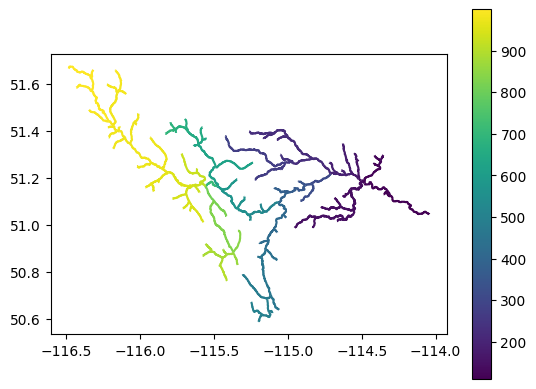

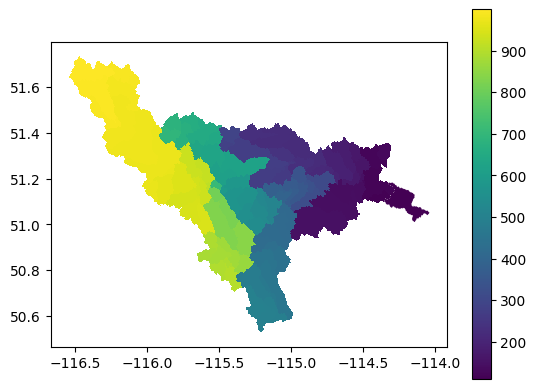

In [12]:
riv_slice = riv_slice.rename(columns={'COMID': 'id', 'NextDownID': 'next', 'uparea': 'upa', 'unitarea': 'a'})
cat_slice = cat_slice.rename(columns={'COMID': 'id'})

# caclulate pfaf for riv_slice
riv_slice = pfaf(riv_slice)

# pass pfaf to cat_slice
cat_slice['pfaf'] = riv_slice['pfaf']


# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)

# # Create a new figure and axes
fig, ax = plt.subplots()

# Plot the first river GeoDataFrame
cat_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)


number of shape:  1


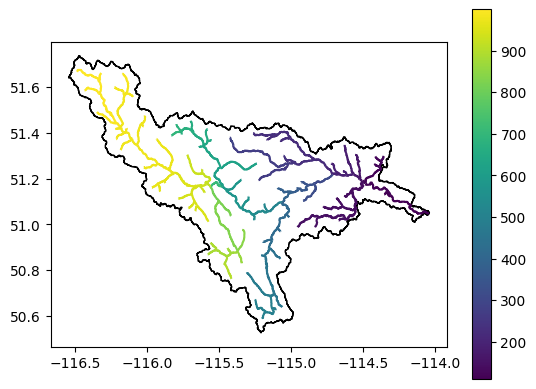

In [18]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=0):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  9


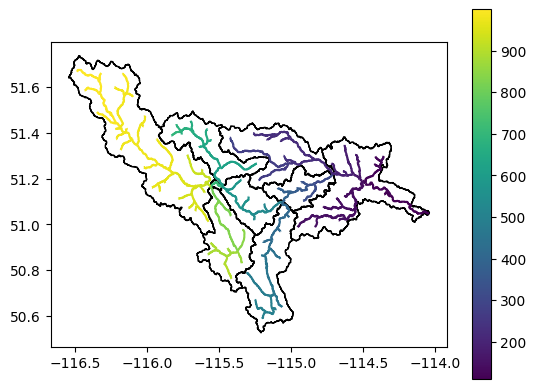

In [19]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=1):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  73


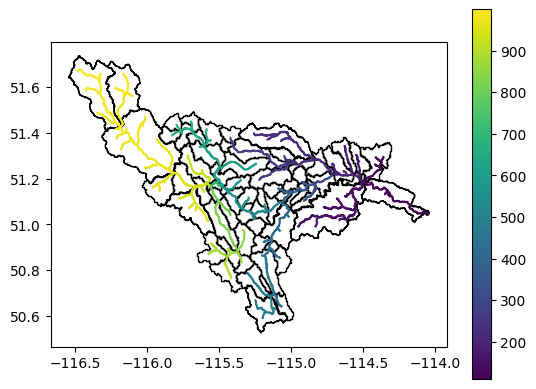

In [20]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=2):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  159


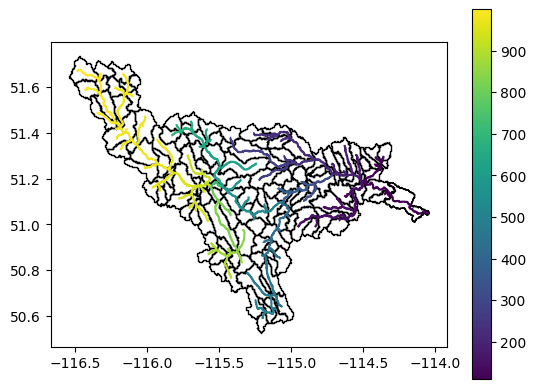

In [21]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=3):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))

number of shape:  159


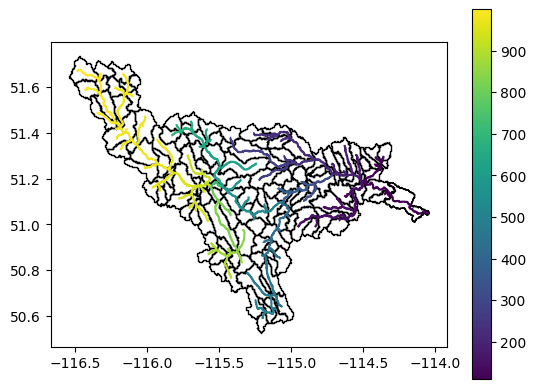

In [22]:
# Function to extract the first n digits
def extract_first_n_digits(x,n=4):
    return str(x)[:n]

# Apply the function to create a new column
cat_slice['pfaf_temp'] = cat_slice['pfaf'].apply(extract_first_n_digits)

# Dissolve based on the new column
cat_slice_agg = cat_slice.dissolve(by='pfaf_temp')

# # Create a new figure and axes
fig, ax = plt.subplots()
riv_slice.plot(column='pfaf', cmap='viridis', legend=True, ax=ax)
cat_slice_agg.plot(facecolor='none', ax=ax)

# print the aggregated shapes
print('number of shape: ', len(cat_slice_agg))